In [1]:
# pip install yfinance
# pip install pandas
# pip install numpy
# pip install matplotlib
# pip install scikit-learn
# pip install keras


In [2]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from keras.layers import LSTM, Dense, Dropout
from keras.models import Sequential
from datetime import datetime, timedelta


In [3]:
# 1. Load Bitcoin data from yfinance
end_date = datetime.now().strftime("%Y-%m-%d")
data = yf.download('BTC-USD', start='2015-01-01', end=end_date)

[*********************100%***********************]  1 of 1 completed


In [4]:
data.tail()

Price,Adj Close,Close,High,Low,Open,Volume
Ticker,BTC-USD,BTC-USD,BTC-USD,BTC-USD,BTC-USD,BTC-USD
Date,,,,,,
2024-11-22 00:00:00+00:00,98997.664062,98997.664062,99655.500000,97222.664062,98496.429688,78473580551
2024-11-23 00:00:00+00:00,97777.281250,97777.281250,99014.679688,97232.890625,99006.742188,44414644677
2024-11-24 00:00:00+00:00,98013.820312,98013.820312,98647.179688,95788.078125,97778.093750,51712020623
2024-11-25 00:00:00+00:00,93102.296875,93102.296875,98935.031250,92642.914062,98033.445312,80909462490
2024-11-26 00:00:00+00:00,91985.320312,91985.320312,94991.750000,90770.812500,93087.281250,91656519855


In [5]:
print(data.columns)

MultiIndex([('Adj Close', 'BTC-USD'),
            (    'Close', 'BTC-USD'),
            (     'High', 'BTC-USD'),
            (      'Low', 'BTC-USD'),
            (     'Open', 'BTC-USD'),
            (   'Volume', 'BTC-USD')],
           names=['Price', 'Ticker'])


In [6]:
# 2. Prepare the data
data = pd.DataFrame(data)
data.reset_index(inplace=True)
data = data[['Close']]  # Keep only 'Close' price
data.dropna(inplace=True)

In [7]:
# 3. Train-test split
train_data = data[:-100]
test_data = data[-100:]

In [8]:
# 4. Normalize the data
scaler = MinMaxScaler(feature_range=(0, 1))
train_data_scaled = scaler.fit_transform(train_data)

In [9]:
# 5. Prepare sequences
base_days = 100
x_train, y_train = [], []
for i in range(base_days, len(train_data_scaled)):
    x_train.append(train_data_scaled[i - base_days:i])
    y_train.append(train_data_scaled[i, 0])
x_train, y_train = np.array(x_train), np.array(y_train)
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))

In [10]:
# 6. Build the LSTM model
model = Sequential()
model.add(LSTM(50, activation='relu', return_sequences=True, input_shape=(x_train.shape[1], 1)))
model.add(Dropout(0.2))
model.add(LSTM(60, activation='relu', return_sequences=True))
model.add(Dropout(0.3))
model.add(LSTM(80, activation='relu'))
model.add(Dropout(0.4))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mean_squared_error')

D:\Anaconda\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [11]:
# 7. Train the model
model.fit(x_train, y_train, epochs=50, verbose=1)

Epoch 1/50
107/107 ━━━━━━━━━━━━━━━━━━━━ 17s 113ms/step - loss: 0.0355
Epoch 2/50
107/107 ━━━━━━━━━━━━━━━━━━━━ 13s 120ms/step - loss: 0.0047
Epoch 3/50
107/107 ━━━━━━━━━━━━━━━━━━━━ 12s 113ms/step - loss: 0.0047
Epoch 4/50
107/107 ━━━━━━━━━━━━━━━━━━━━ 12s 113ms/step - loss: 0.0044
Epoch 5/50
107/107 ━━━━━━━━━━━━━━━━━━━━ 12s 114ms/step - loss: 0.0039
Epoch 6/50
107/107 ━━━━━━━━━━━━━━━━━━━━ 14s 133ms/step - loss: 0.0032
Epoch 7/50
107/107 ━━━━━━━━━━━━━━━━━━━━ 14s 130ms/step - loss: 0.0041
Epoch 8/50
107/107 ━━━━━━━━━━━━━━━━━━━━ 13s 124ms/step - loss: 0.0034
Epoch 9/50
107/107 ━━━━━━━━━━━━━━━━━━━━ 14s 127ms/step - loss: 0.0026
Epoch 10/50
107/107 ━━━━━━━━━━━━━━━━━━━━ 13s 125ms/step - loss: 0.0033
Epoch 11/50
107/107 ━━━━━━━━━━━━━━━━━━━━ 14s 132ms/step - loss: 0.0028
Epoch 12/50
107/107 ━━━━━━━━━━━━━━━━━━━━ 13s 124ms/step - loss: 0.0028
Epoch 13/50
107/107 ━━━━━━━━━━━━━━━━━━━━ 13s 123ms/step - loss: 0.0024
Epoch 14/50
107/107 ━━━━━━━━━━━━━━━━━━━━ 13s 120ms/step - loss: 0.0024
Epoch 15/50
107

In [12]:
# 8. Prepare test data
total_data = pd.concat((train_data, test_data), axis=0, ignore_index=True)
test_data_scaled = scaler.transform(total_data)
x_test, y_test = [], []
for i in range(base_days, len(test_data_scaled)):
    x_test.append(test_data_scaled[i - base_days:i])
    y_test.append(test_data_scaled[i, 0])
x_test, y_test = np.array(x_test), np.array(y_test)
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

In [13]:
# 9. Make predictions
predictions = model.predict(x_test)
predictions = scaler.inverse_transform(predictions)

110/110 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step


In [14]:
# 10. Predict future prices for 5 days
future_prices = {}
current_input = test_data_scaled[-base_days:]  # Start with the last 100 days
for i in range(1, 6):  # Predict for the next 5 days
    future_pred = model.predict(current_input.reshape(1, base_days, 1))
    future_date = (datetime.now() + timedelta(days=i)).strftime('%Y-%m-%d')
    future_prices[future_date] = scaler.inverse_transform(future_pred)[0][0]
    current_input = np.append(current_input[1:], future_pred, axis=0)  # Slide the window


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


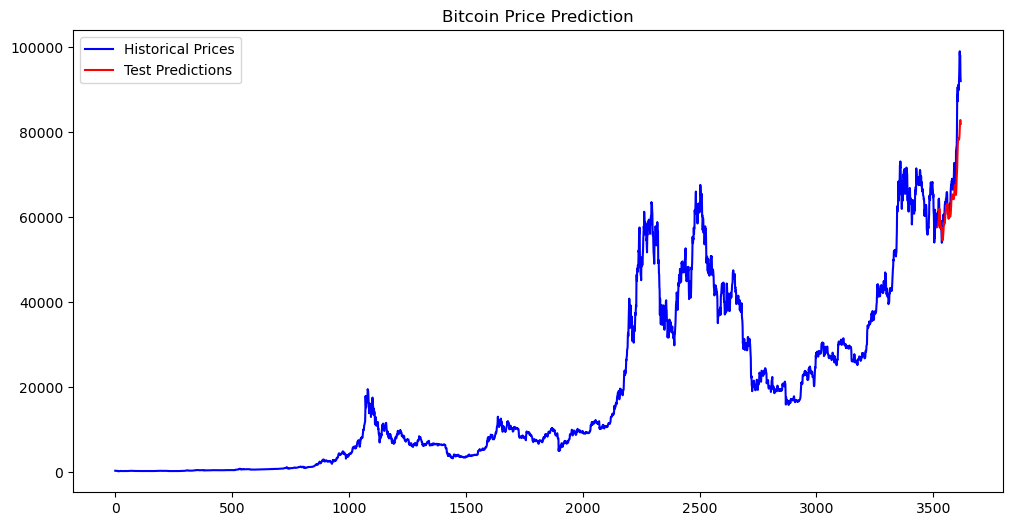

In [15]:
# Adjust predictions to match the last 100 test samples
test_predictions = predictions[-100:]  # Take the last 100 predictions

# Plot the predictions
plt.figure(figsize=(12, 6))
plt.plot(data['Close'], label="Historical Prices", color="blue")
plt.plot(range(len(data) - 100, len(data)), test_predictions, label="Test Predictions", color="red")
plt.title("Bitcoin Price Prediction")
plt.legend()
plt.show()

In [16]:
# 11. Results: Display future prices in a table and save to CSV
future_prices_df = pd.DataFrame(
    list(future_prices.items()), columns=["Date", "PredictedPrice"]
)

# Save the table to a CSV file
future_prices_df.to_csv("BTC_predicted_prices.csv", index=False)

# Display the table in the notebook
future_prices_df


,Date,PredictedPrice
0,2024-11-29,80728.578125
1,2024-11-30,78257.257812
2,2024-12-01,75476.820312
3,2024-12-02,72889.750000
4,2024-12-03,70791.203125
